# Econometrics of Big Data Final Problem
*by Christian Stolborg*

*15-07-2022*

## Part A
### Data Transformations

Before beginning the problem set, I do some preliminary data transformations to align the data with the Julia ML ecosystem. I also split the data in train/test sets and create a "flexible" data set consisting of polynomial transformations of order two and three of all continous variables and interaction terms between all variables. This "flexible" data structure will be used later in estimating Lasso and Ridge regressions.

In [1]:
using MLJ, DataFrames, CSV
import Logging

Logging.disable_logging(Logging.LogLevel(999));  # Disable info logs, but keep warnings

In [2]:
df = CSV.read("./data/401ksubs.csv", DataFrame)
first(df, 5)

,net_tfa,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,0,47,6765,2,8,0,0,0,0,0,0
2,1015,36,28452,1,16,0,0,0,0,0,0
3,-2000,37,3300,6,12,1,0,0,0,0,0
4,15000,58,52590,2,16,0,1,1,0,0,0
5,0,32,21804,1,11,0,0,0,0,0,0


In [3]:
describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Int64,Float64,Int64,Int64,DataType
1,net_tfa,18051.5,-502302,1499.0,1536798,0,Int64
2,age,41.0602,25,40.0,64,0,Int64
3,inc,37200.6,-2652,31476.0,242124,0,Int64
4,fsize,2.86586,1,3.0,13,0,Int64
5,educ,13.2063,1,12.0,18,0,Int64
6,db,0.271004,0,0.0,1,0,Int64
7,marr,0.604841,0,1.0,1,0,Int64
8,twoearn,0.380837,0,0.0,1,0,Int64
9,e401,0.371357,0,0.0,1,0,Int64


In [4]:
# Get correct types
df[!, 1:5] = coerce(df[!, 1:5], Count => Continuous)
df[!, 6:end] = coerce(df[!, 6:end], Count => Multiclass)
schema(df) |> pretty

┌─────────┬───────────────┬─────────────────────────────────┐
│ names   │ scitypes      │ types                           │
│ Symbol  │ Type          │ Type                            │
│ Unknown │ Unknown       │ Unknown                         │
├─────────┼───────────────┼─────────────────────────────────┤
│ net_tfa │ Continuous    │ Float64                         │
│ age     │ Continuous    │ Float64                         │
│ inc     │ Continuous    │ Float64                         │
│ fsize   │ Continuous    │ Float64                         │
│ educ    │ Continuous    │ Float64                         │
│ db      │ Multiclass{2} │ CategoricalValue{Int64, UInt32} │
│ marr    │ Multiclass{2} │ CategoricalValue{Int64, UInt32} │
│ twoearn │ Multiclass{2} │ CategoricalValue{Int64, UInt32} │
│ e401    │ Multiclass{2} │ CategoricalValue{Int64, UInt32} │
│ p401    │ Multiclass{2} │ CategoricalValue{Int64, UInt32} │
│ pira    │ Multiclass{2} │ CategoricalValue{Int64, UInt32} │
│ hown  

In [5]:
frac = 6000 / size(df)[1]  # Fraction of data that equals 6000 obs
df, df_test = partition(df, frac, rng=42)

X_cols = split("age,inc,fsize,educ,db,marr,twoearn,pira,hown", ",")
X, y = df[!, X_cols], df[!, :net_tfa]
println("Size of X = ",size(X))
first(X, 4)

Size of X = (6000, 9)


,age,inc,fsize,educ,db,marr,twoearn,pira,hown
,Float64,Float64,Float64,Float64,Cat…,Cat…,Cat…,Cat…,Cat…
1,43.0,47094.0,4.0,14.0,0,1,0,0,1
2,31.0,30315.0,4.0,13.0,0,1,0,0,1
3,27.0,38640.0,2.0,16.0,1,1,1,0,0
4,62.0,13317.0,1.0,11.0,0,0,0,0,1


In [6]:
""" Nonlinear transformations of data - take interactions and add higher-order terms """
function nl_transform(df)
    # Add a second and third exponent of all numerical columns
    num_cols = [:age, :inc, :fsize, :educ]
    sq(x) = x.^2
    cub(x) = x.^3
    for p in [sq, cub]
        transform!(df, num_cols .=> p)
    end
    

    # Take interaction terms between everything
    cat_cols = [:db, :marr, :twoearn, :pira, :hown]
    df[!, cat_cols] = coerce(df[!, cat_cols], Multiclass => Continuous)  # Transform Categorical to Continuous
    cols = names(df)
    for col1 in cols
        for col2 in cols
            c1 = split(col1, "_")[1]
            c2 = split(col2, "_")[1]
            if c1 != c2
                df[!, col1*"_"*col2] = df[!, col1] .* df[!, col2]
            end
        end
    end
    
    df[!, cat_cols] = coerce(df[!, cat_cols], Continuous => Multiclass)  # Convert back to Categorical type
    
    return df
end
   
X_flex = copy(X)
nl_transform(X_flex)

# Standardize numerical variables then onehot encode categorical variables
transformer = Standardizer() |> OneHotEncoder()
transformer = fit!(machine(transformer, X_flex))
X_flex = MLJ.transform(transformer, X_flex)

X_basic = copy(X)
X = machine(ContinuousEncoder(), X) |> fit! |> MLJ.transform;  # Used for non-linear ML models

first(X_flex, 3)

,age,inc,fsize,educ,db__1.0,db__2.0,marr__1.0,marr__2.0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.18438,0.408248,0.73133,0.280414,1.0,0.0,0.0,1.0
2,-0.973723,-0.267984,0.73133,-0.0701765,1.0,0.0,0.0,1.0
3,-1.35976,0.0675325,-0.557925,0.981595,0.0,1.0,0.0,1.0


### (i) Estimate $E[net\_tfa]$

In [7]:
mean(y)

18367.1

### (ii) Using linear regression estimate $E[net\_tfa|X = \{age, inc, fsize, educ, db, marr, twoearn, pira, hown\}]$

In [8]:
LinearRegressor = (@load LinearRegressor pkg=MLJLinearModels verbosity=0)()
lm_pipe = ContinuousEncoder(drop_last=true) |> LinearRegressor
lm = machine(lm_pipe, X_basic, y) |> fit!;

In [9]:
# Display model results
fp = fitted_params(lm).linear_regressor
coefs = fp.coefs
intercept = fp.intercept
println("Intercept: $(round(intercept, sigdigits=3))")
for (name, val) in coefs
    println("$(rpad(name, 8)):  $(round(val, sigdigits=3))")
end

Intercept: -30800.0
age     :  657.0
inc     :  0.991
fsize   :  -855.0
educ    :  -364.0
db__0   :  3540.0
marr__0 :  624.0
twoearn__0:  18700.0
pira__0 :  -27700.0
hown__0 :  -1910.0


### (iii) Lasso

In this section I take higher order transformations of $X$ and estimate a Lasso model. Concretely, I take powers of two and three and compute interaction terms between all variables. I make these interactions because it provides quite a lot of flexibility for the lasso model to choose only the most important parameters, while also keeping the computing resources required somewhat reasonable and fast (my setup results in 270 variables).

In [10]:
LassoRegressor = @load LassoRegressor pkg=MLJLinearModels

import MLJLinearModels ✔


MLJLinearModels.LassoRegressor

In [11]:
r  = range(LassoRegressor(), :(lambda), lower=50, upper=1000)
tm = TunedModel(model=LassoRegressor(), ranges=r, tuning=Grid(resolution=50),
                resampling=CV(nfolds=5, rng=42), measure=rms)

#lasso_tm = machine(tm, X_flex, y) |> fit!
#MLJ.save("MLmodels/lasso.jls", lasso_tm)
lasso_tm = machine("MLmodels/lasso.jls")


# Print results
best_mdl = fitted_params(lasso_tm).best_model
coefs, intercept = fitted_params(lasso_tm).best_fitted_params

# Get non-zero coefs
coef_vals = [c[2] for c in coefs]

println("Opimtal penalty: ", round(best_mdl.lambda, sigdigits=4))
println("Pct. variables set to zero: ", round(sum(coef_vals .≈ 0) / length(coefs)*100, sigdigits=2),"%" )
@show intercept

Opimtal penalty: 592.9
Pct. variables set to zero: 86.0%
intercept = 18367.17287771169


18367.17287771169

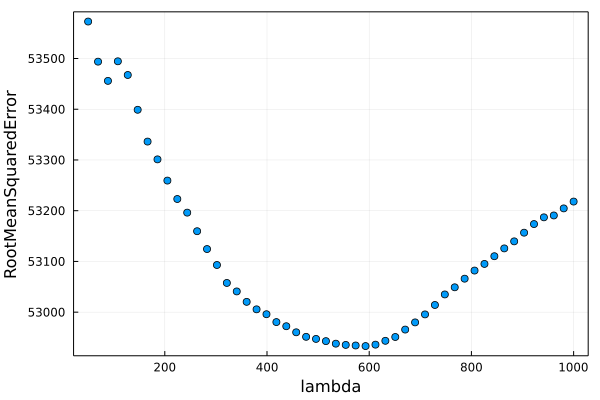

In [12]:
using Plots
plot(lasso_tm, size=(600, 400))

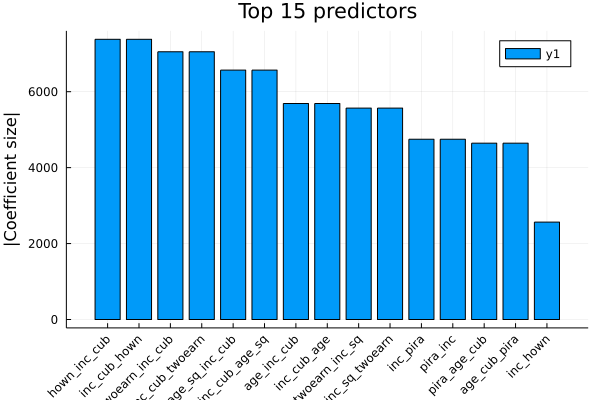

In [13]:
coefs = coefs[.~(coef_vals .≈ 0)]
coef_names = string.([c[1] for c in coefs])
coef_vals = [abs(c[2]) for c in coefs]

coefs = DataFrame(coef_names=coef_names, coef_vals=coef_vals)
sort!(coefs, :coef_vals, rev=true)

bar(coefs[1:15, 1], coefs[1:15, 2], ylabel="|Coefficient size|", xrotation = 45, title="Top 15 predictors", size=(600, 400))

The procedure results in 86\% of the 270 constructed terms being set to approximately zero and 38 variables being nonzero. As a result, there are now more than 4 times more predictor variables present than in the linear regression model. Interestingly, the model appear to choose only interaction terms where at least one of the terms is either squared or cubed. This is a strong indication that the prediction problem is non-linear and one should therefore exepct the Lasso model to outperform OLS.

### (iv) Ridge

In this section I repeat the above procedure using a Ridge regression.

In [14]:
RidgeRegressor = @load RidgeRegressor pkg=MLJLinearModels;

import MLJLinearModels ✔


Evaluating over 50 metamodels: 100%[=========================] Time: 0:00:10


Opimtal penalty: 0.1326
intercept = 18954.440283050226


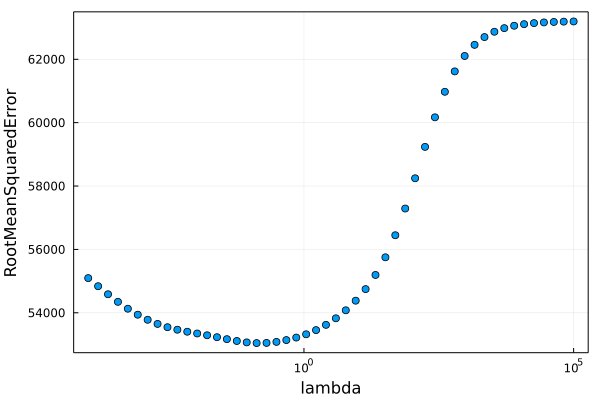

In [15]:
r  = range(RidgeRegressor(), :(lambda), lower=0.0001, upper=100_000, scale=:log10)
tm = TunedModel(model=RidgeRegressor(), ranges=r, tuning=Grid(resolution=50),
                resampling=CV(nfolds=5, rng=42), measure=rms)

ridge_tm = machine(tm, X_flex, y) |> fit!
best_mdl = fitted_params(ridge_tm).best_model

# Print results
println("Opimtal penalty: ", round(best_mdl.lambda, sigdigits=4))
coefs, intercept = fitted_params(ridge_tm).best_fitted_params
@show intercept

plot(ridge_tm, size=(600, 400))

### (v) Decision tree

In [16]:
DecisionTreeRegressor = @load DecisionTreeRegressor pkg=DecisionTree

import MLJDecisionTreeInterface ✔


MLJDecisionTreeInterface.DecisionTreeRegressor

In [17]:
DecisionTreeRegressor

MLJDecisionTreeInterface.DecisionTreeRegressor

In [18]:
r1 = range(DecisionTreeRegressor(), :max_depth, lower=1, upper=5)
r2 = range(DecisionTreeRegressor(), :min_samples_leaf, lower=5, upper=100,)

tm = TunedModel(model=DecisionTreeRegressor(), ranges=[r1, r2], tuning=Grid(resolution=50),
                resampling=CV(nfolds=5, rng=42), measure=rms)

tree = machine(tm, X, y) |> fit!

fp = fitted_params(tree).best_model

Evaluating over 250 metamodels: 100%[=========================] Time: 0:00:06


DecisionTreeRegressor(
  max_depth = 3, 
  min_samples_leaf = 7, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = 0, 
  post_prune = false, 
  merge_purity_threshold = 1.0, 
  rng = Random._GLOBAL_RNG())

In [19]:
import DecisionTree
DecisionTree.print_tree(tree.fitresult.fitresult, sigdigits=1)

Feature 2 < 200000.0 ?
├─ Feature 12 < 0.5 ?
    ├─ Feature 2 < 70000.0 ?
        ├─ 3674.0157498824638 : 0/4254
        └─ 37326.37455830388 : 0/283
    └─ Feature 2 < 60000.0 ?
        ├─ 38363.41998060136 : 0/1031
        └─ 91199.4893111639 : 0/421
└─ 551118.3636363636 : 0/11


From the final tree structure, Feature 2 (income) and Feature 11 (pira=0) are important. The tree clearly captures some interaction terms between these two features as Income is both in the top node as well as in a leaf node.

### (vi) Random Forest

In this section I train a random forest. I use 100 bootstrap replications and also tune over the number of features to use and the bagging fraction to use.

In [20]:
forest = EnsembleModel(model=DecisionTreeRegressor())

DeterministicEnsembleModel(
  model = DecisionTreeRegressor(
        max_depth = -1, 
        min_samples_leaf = 5, 
        min_samples_split = 2, 
        min_purity_increase = 0.0, 
        n_subfeatures = 0, 
        post_prune = false, 
        merge_purity_threshold = 1.0, 
        rng = Random._GLOBAL_RNG()), 
  atomic_weights = Float64[], 
  bagging_fraction = 0.8, 
  rng = Random._GLOBAL_RNG(), 
  n = 100, 
  acceleration = CPU1{Nothing}(nothing), 
  out_of_bag_measure = Any[])

In [21]:
r1 = range(forest, :(model.n_subfeatures), lower=1, upper=5)
r2 = range(forest, :bagging_fraction, lower=0.4, upper=1.0)
tm = TunedModel(model=forest, tuning=Grid(resolution=12),
                resampling=CV(nfolds=6), ranges=[r1, r2],
                measure=rms)

#forest_tm = machine(tm, X, y) |> fit!
#MLJ.save("MLmodels/forest.jls", forest_tm)
forest_tm = machine("MLmodels/forest.jls")

best_mdl = fitted_params(forest_tm).best_model
@show n_bootstraps = best_mdl.n
@show n_subfeatures = best_mdl.model.n_subfeatures
@show bagging_fraction = best_mdl.bagging_fraction;

n_bootstraps = best_mdl.n = 100
n_subfeatures = best_mdl.model.n_subfeatures = 5
bagging_fraction = best_mdl.bagging_fraction = 0.5636363636363636


In [ ]:
using ShapML, Gadfly

function predict_function(model, data)
  data_pred = DataFrame(y_pred = predict(model, data))
  return data_pred
end

explain = copy(X)
reference = copy(X)

@time data_shap = ShapML.shap(explain = explain,
                        model = forest_tm,
                        predict_function = predict_function,
                        sample_size = 60,
                        seed = 42
                        )

function plot_shap(data_shap)
    data_plot = combine(groupby(data_shap, :feature_name), :shap_effect => (x -> mean(abs.(x)) ) => :mean_effect )
    data_plot = sort(data_plot, order(:mean_effect, rev = true))

    baseline = round(data_shap.intercept[1], digits = 1)

    p = plot(data_plot, y = :feature_name, x = :mean_effect, Coord.cartesian(yflip = true),
             Scale.y_discrete, Geom.bar(position = :dodge, orientation = :horizontal),
             Theme(bar_spacing = 1mm),
             Guide.xlabel("|Shapley effect| (baseline = $baseline)"), Guide.ylabel(nothing),
             Guide.title("Feature Importance - Mean Absolute Shapley Value"))
end


p = plot_shap(data_shap)

<img src="images/forest_shap.png" alt="drawing" width="700"/>

From the shapley values above, it is clear that income and pira=0 is again important (as in the decision tree). Age and twoearn=0 are also somewhat important now.

### (vii) Boosted trees

In this section I train XGB trees. I tune over the number of iterations and the maximum depth of each tree using 5-fold CV.

In [22]:
XGBR = @load XGBoostRegressor;

import MLJXGBoostInterface ✔


In [23]:
r1 = range(XGBR(), :num_round, lower=1, upper=20)
r2 = range(XGBR(), :max_depth, lower=1, upper=5)

tm = TunedModel(model=XGBR(), tuning=Grid(resolution=50),
                resampling=CV(nfolds=5 ,rng=42), ranges=[r1, r2],
                measure=rms)

xgb = machine(tm, X, y) |> fit!
best_mdl = fitted_params(xgb).best_model
@show num_round = best_mdl.num_round
@show max_depth = best_mdl.max_depth;

Evaluating over 100 metamodels: 100%[=========================] Time: 0:00:09


num_round = best_mdl.num_round = 17
max_depth = best_mdl.max_depth = 2


In [ ]:
@time data_shap = ShapML.shap(explain = explain,
                        model = xgb,
                        predict_function = predict_function,
                        sample_size = 60,
                        seed = 42
                        );

plot_shap(data_shap)

<img src="images/xgb_shap.png" alt="drawing" width="700"/>

I end up using a tree depth of 2. The XGB regressor seems largely consistent with the Random Forest, when evaluated on Shapley values.

### (viii) Neural net

In this section I train a neural net. I use two hidden layers, each with 32 nodes in them and the ReLu activation function. This choice was chosen amongst a subset of both deep and shallow neural nets, which I tested. That is, I tried a shallow net of one hidden layer with 64 nodes, another net with two hidden layers and 32 nodes in each hidden layer, and a deep neural net with 4 hidden layers and 8 nodes in each layer. I decided to do drop-out regularization, dropping 50\% after each layer, which seemed to be the best regularizer amongst the three models - I tried different percentages and also adding early stopping, but it didn't seem to matter much for the model performance.

In [24]:
import MLJFlux
import Flux
NeuralNetworkRegressor = @load NeuralNetworkRegressor;

import MLJFlux ✔


In [25]:
mutable struct MyNetworkBuilder <: MLJFlux.Builder
    n1::Int #Number of cells in the first hidden layer
    n2::Int #Number of cells in the second hidden layer
    dropout::Float64
    σ
end

MyNetworkBuilder(; n1=32, n2=32, dropout=0.5, σ=Flux.relu) = MyNetworkBuilder(n1, n2, dropout, σ)

function MLJFlux.build(model::MyNetworkBuilder, rng, n_in, n_out)
    n1, n2 = model.n1, model.n2
    dropout, σ = model.dropout, model.σ
    
    init = Flux.glorot_uniform(rng)
    layer1 = Flux.Dense(n_in, n1, σ, init=init)
    layer1_drop = Flux.Dropout(dropout)
    layer2 = Flux.Dense(n1, n2, σ, init=init)
    layer2_drop = Flux.Dropout(dropout)
    layer3 = Flux.Dense(model.n2, n_out, init=init)
    return Flux.Chain(layer1, layer1_drop, layer2, layer2_drop, layer3)
end

nnregressor = NeuralNetworkRegressor(builder=MyNetworkBuilder(), epochs=10)

NeuralNetworkRegressor(
  builder = MyNetworkBuilder(
        n1 = 32, 
        n2 = 32, 
        dropout = 0.5, 
        σ = NNlib.relu), 
  optimiser = Flux.Optimise.Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), 
  loss = Flux.Losses.mse, 
  epochs = 10, 
  batch_size = 1, 
  lambda = 0.0, 
  alpha = 0.0, 
  rng = Random._GLOBAL_RNG(), 
  optimiser_changes_trigger_retraining = false, 
  acceleration = CPU1{Nothing}(nothing))

In [26]:
#nn = machine(nnregressor, X, y) |> fit!
#MLJ.save("MLmodels/nn.jls", nn)
nn = machine("MLmodels/nn.jls")

Machine trained 1 time; caches data
  model: NeuralNetworkRegressor(builder = MyNetworkBuilder(n1 = 32, …), …)
  args: 


In [ ]:
@time data_shap = ShapML.shap(explain = explain,
                        model = nn,
                        predict_function = predict_function,
                        sample_size = 60,
                        seed = 42
                        );

plot_shap(data_shap)

<img src="images/nn_shap.png" alt="drawing" width="700"/>

The neural net appear to only focus on income, setting all the other coefficients close to zero.

### Ensemble

In this section I stack all previous models, by finding the combination of learners that minimize overall MSE in training.

In [27]:
# Compute predictions of all models, then stack them
MLmodels = [tree, forest_tm, xgb, nn]
M = zeros(length(y), 7)

M[:, 1] = predict(lm , df[!, X_cols])
M[:, 2] = predict(lasso_tm , X_flex)
M[:, 3] = predict(ridge_tm , X_flex)

for i in 1:length(MLmodels)
    M[:, i+3] = predict(MLmodels[i], X)
end

In [28]:
using IJulia, Conda
Conda.add("scipy");

Solving environment: ...working... done

# All requested packages already installed.



In [30]:
# Compute stacking weights with Python's Scipy library
using PyCall

f(w) = (y .- M*w)' * (y .- M*w)

n_models = size(M)[2]
x0 = ones(n_models) * (1/n_models)

py"""
import numpy as np
import scipy.optimize as opt
cons = {'type':'eq', 'fun': lambda w: np.sum(np.abs(w))-1}
cons1 = ({'type':'eq', 'fun': lambda w: np.sum(np.abs(w))-1},
        {'type':'ineq', 'fun': lambda w: np.array(w)})


res = opt.minimize($f, $x0, constraints=cons)
"""
println(py"res.message")
w = py"res.x"   # Stacking weights

Iteration limit reached


7-element Vector{Float64}:
 -2.5360341577319046e-7
  1.3218466230751566e-6
  3.8709687187601174e-7
  1.5429030004269632e-6
  0.9999982564587033
  2.0705104983425046e-7
  2.8634315061041944e-8

In [31]:
ensemble_preds = w' .* M[:, 1:end] |> x -> sum(x, dims=2)
M = hcat(M, ensemble_preds);

It is clear that the ensemble basically loads 100\% on the random forest. Thus they will likely have very similar performance on the test set.

## Mean-square forecast error of all models

In [32]:
X_test, y_test = df_test[!, X_cols], df_test[!, :net_tfa]

# Do data transformations on test set
X_test_f = copy(X_test)
nl_transform(X_test_f)
X_test_f = MLJ.transform(transformer, X_test_f)

X_test = machine(ContinuousEncoder(), X_test) |> fit! |> MLJ.transform;  # Onehot-encode categorical variables

In [33]:
# Compute predictions of all models, then stack them
MLmodels = [tree, forest_tm, xgb, nn]
G = zeros(length(y_test), 8)

G[:, 1] = predict(lm , df_test[!, X_cols])
G[:, 2] = predict(lasso_tm , X_test_f)
G[:, 3] = predict(ridge_tm , X_test_f)

for i in 1:length(MLmodels)
    G[:, i+3] = predict(MLmodels[i], X_test)
end

G[:, end] = w' .* G[:, 1:end-1] |> x -> sum(x, dims=2)  # Ensemble predictions

msfe = (G .- y_test).^2  # mean square forecast error
msfe_mean = mean(msfe, dims=1)
msfe_std = std(msfe, dims=1) / sqrt(length(y_test))

mse = (M .- y).^2
mse_mean = mean(mse, dims=1)

res = DataFrame(Model=["OLS", "Lasso", "Ridge", "Tree", "RF", "XGB", "NN", "Ensemble"],
          Train_MSE=mse_mean[:],
          Test_MSE=msfe_mean[:],
          Test_MSE_SE=msfe_std[:])
          
sort!(res, :Test_MSE)

,Model,Train_MSE,Test_MSE,Test_MSE_SE
,String,Float64,Float64,Float64
1,Lasso,2.60924e9,2.84833e9,7.57937e8
2,Ridge,2.59649e9,2.85141e9,7.55092e8
3,Ensemble,2.10081e9,3.0386e9,7.81582e8
4,RF,2.10081e9,3.0386e9,7.81582e8
5,XGB,2.37597e9,3.1137e9,7.87585e8
6,OLS,3.03314e9,3.22963e9,8.07457e8
7,Tree,2.85783e9,3.23919e9,7.91188e8
8,NN,3.64473e9,3.79006e9,9.24879e8


Lasso and Ridge appear to do the best job in predicting net financial assets, both in terms of test_MSE and the associated standard error. Note, that the random forest has the best perfomance in-sample, which likely also explains why the ensemble model loads 100\% on that specific model. 

The difference in performance doesn't seem very high out-of-sample, except for the neural net, ridge and Lasso. The Neural Net also performs poorly in-sample and has very high-standard errors. This can potentially be because the Neural Net needs more training epochs to converge.

In conclusion, there is definitely some improvement over OLS both in- and out-of-sample. This is especially true in-sample, yet the ML models doesn't seem to outperform too much out-of-sample.